# Challenge: Factors that affect life expectancy

In this challenge, you'll work with the Life Expectancy dataset from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

<b> Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.</b>

1) First, load the dataset.

2) Detect the problems with the data such as missing values and outliers. 
    - Are there any nonsense values that seem to be stemmed from the data collection? 
    - For the missing values, discuss which technique would be the most suitable one in filling out these values.    
    - Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to 
      deal with them.

3) Explore the data using univariate and multivariate exploration techniques. 
    - You should pay special attention to your target variable. 
    - In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

4) In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. 
    - More concretely, you may discard some variables that are very correlated with the other ones or the variables 
      that you think irrelevant with the life expectancy.

5) Summarize your findings using effective visualization.

In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import sklearn
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [2]:
#Import dataset from postgres sql server

#defines the logon credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

#opens the connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host,
    postgres_port, postgres_db))

#queries the schema
expectancy_df = pd.read_sql_query('select * from lifeexpectancy', con=engine)

#closes the connection
engine.dispose()

### 2) Detect the problems with the data such as missing values and outliers and perform data cleaning exercises

In [3]:
#begin with exploration of the data; understand what we have
expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
expectancy_df.isnull().sum()/expectancy_df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [5]:
expectancy_df.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [6]:
#strip any leading or trailing white spaces
expectancy_df.columns=expectancy_df.columns.str.strip()

In [7]:
#Replace missing values using .mean() for categories whose values will differ by country: Expenditure, 
#Life Expectancy, Adult Mortality, Income, Schooling, Hep B & Alcohol.  Use the average for these features
#as the variability over the 15 years would make this a safe calculation

names=['Life expectancy', 'Adult Mortality', 'Alcohol','Hepatitis B', 'BMI', 'Polio','Total expenditure', 
      'Diphtheria', 'GDP', 'Income composition of resources', 'Schooling']

for name in names:
    expectancy_df["{}".format(name)]= expectancy_df.groupby(['Country'])["{}".format(name)]\
        .transform(lambda x : x.fillna(x.mean()))

In [8]:
#Replace missing values using .mean() for categories whose values will differ by country & year: 
#GDP, Population, thiness. Use the average for these features
#as the variability over the 15 years would make this a safe calculation

names=['GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years']

for name in names:
    expectancy_df["{}".format(name)]= expectancy_df.groupby(['Country','Year'])["{}".format(name)]\
        .transform(lambda x : x.fillna(x.mean()))

In [9]:
#Replace remainging missing values using interpolation for categories whose values 
#will differ by country & year: GDP, Population, thiness.

names=['GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years']

for name in names:    
    expectancy_df.groupby(['Country']).apply(lambda group: group.interpolate(method='nearest'))

In [10]:
#Replace remaining missing values using interpolation for categories whose values will differ by country & year: 
#GDP, Population, thiness.

names=['GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years']

for name in names:    
    expectancy_df.groupby(['Year']).apply(lambda group: group.interpolate(method='nearest'))

In [11]:
expectancy_df.dropna(subset=['Population', 'GDP', 'Hepatitis B', 'BMI'], inplace=True)

In [12]:
expectancy_df.dropna(inplace=True)

In [13]:
#Check % of missing values 
expectancy_df.isnull().sum()/expectancy_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [14]:
expectancy_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2124,2124.000000,2124,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,...,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2.124000e+03,2124.000000,2124.000000,2124.000000,2124.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Paraguay,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.488701,NaN,68.147175,174.131356,35.959981,4.444948,641.277418,77.240087,2662.206215,...,80.546247,5.893432,80.674401,2.176836,5418.335056,1.342200e+07,5.101412,5.171516,0.607844,11.704426
std,NaN,4.607574,NaN,9.618190,129.822623,136.346604,3.962218,1712.183893,25.273051,11922.951269,...,24.185504,2.255297,24.189849,5.832292,11382.742060,6.321469e+07,4.714014,4.807891,0.203422,3.193070
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2003.000000,NaN,62.000000,75.750000,1.000000,0.830000,20.337002,68.000000,0.000000,...,75.000000,4.370000,76.000000,0.100000,397.110904,1.984078e+05,1.600000,1.600000,0.477000,9.800000
50%,NaN,2007.000000,NaN,70.000000,152.000000,4.000000,3.755000,84.628707,87.000000,20.000000,...,91.000000,5.800000,91.000000,0.100000,1354.840340,1.430108e+06,3.300000,3.400000,0.650500,11.900000
75%,NaN,2011.000000,NaN,74.800000,241.000000,24.000000,7.175000,431.500427,95.000000,461.500000,...,96.000000,7.340000,96.000000,1.300000,4502.502022,7.821252e+06,7.500000,7.600000,0.747000,13.800000


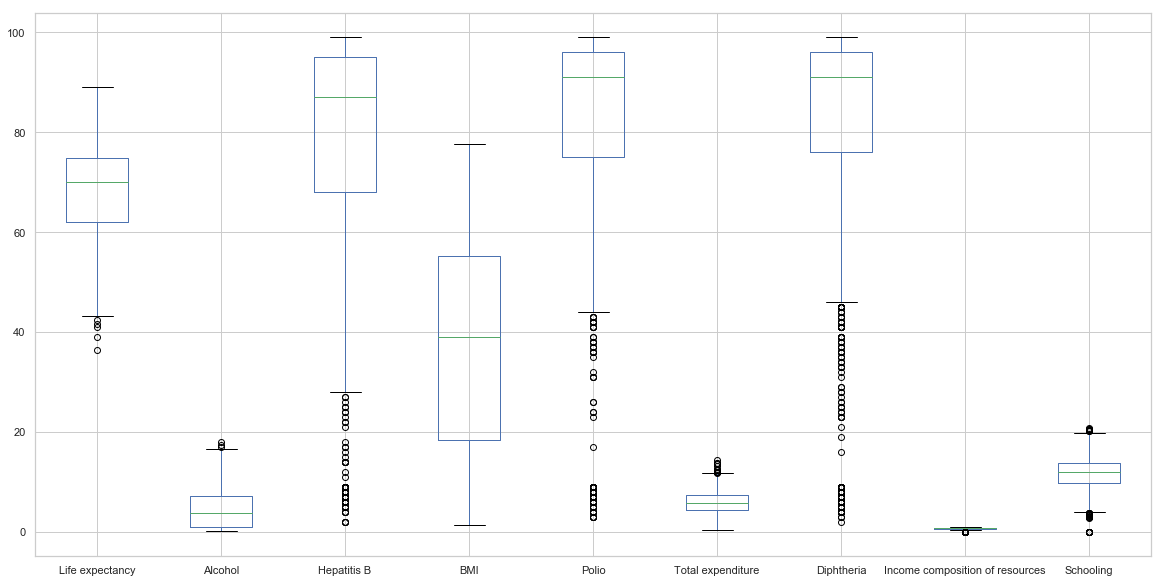

In [15]:
#Check for outliers using boxplots

plt.figure(figsize=(20,10))

boxplot=expectancy_df.boxplot(column=['Life expectancy', 'Alcohol','Hepatitis B', 'BMI', 'Polio','Total expenditure', 
      'Diphtheria','Income composition of resources', 'Schooling'])

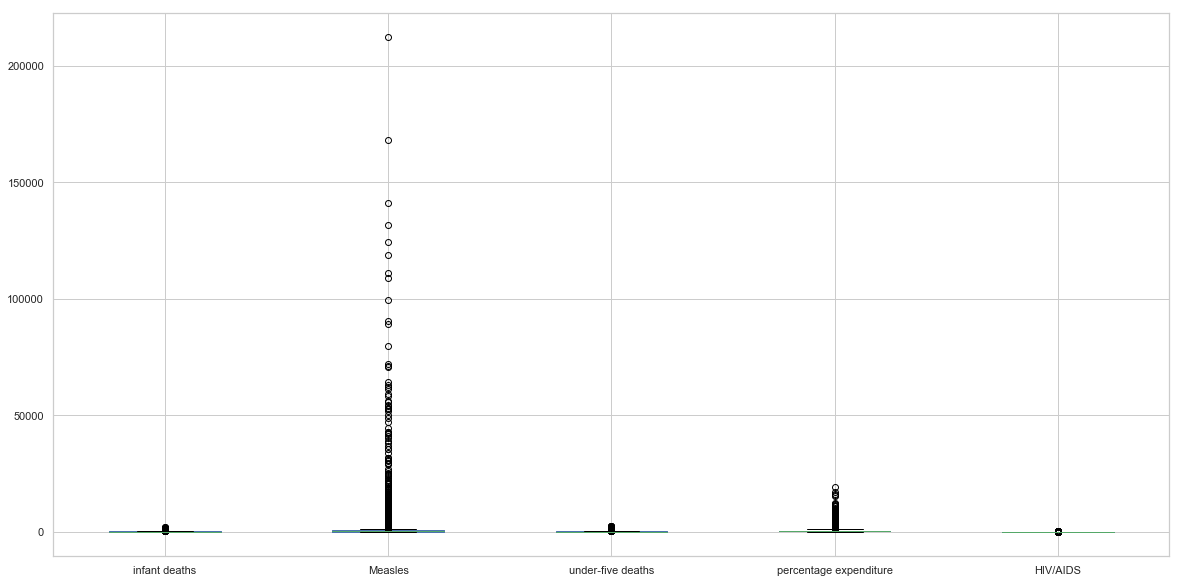

In [16]:
#Check for outliers using boxplots

plt.figure(figsize=(20,10))

boxplot=expectancy_df.boxplot(column=['infant deaths', 'Measles','under-five deaths', 'percentage expenditure',
    'HIV/AIDS'])

In [17]:
#Adjust outliers using winsorization 
names=['Life expectancy', 'Adult Mortality', 'Alcohol','Hepatitis B', 'BMI', 'Polio','Total expenditure', 
      'Diphtheria', 'GDP', 'Income composition of resources', 'Schooling', 'infant deaths', 'Measles',
      'under-five deaths', 'percentage expenditure', 'HIV/AIDS']

for name in names:
    expectancy_df["{}".format(name)]= winsorize(expectancy_df["{}".format(name)], (0.05, .05))

In [18]:
#Use z-score to statistically determine outliers 
from scipy.stats import zscore

numeric_cols=expectancy_df.select_dtypes(include=[np.number]).columns
expectancy_df[numeric_cols].apply(zscore)

z_scores = zscore(expectancy_df[numeric_cols])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   0,    0,    0, ..., 2123, 2123, 2123]), array([ 0,  3,  9, ..., 13, 16, 17]))
Number of outliers is: 5189
The score threshold is: 2
The indices of the outliers:
(array([   0,    0,    1, ..., 2122, 2123, 2123]), array([16, 17, 16, ..., 13,  2, 13]))
Number of outliers is: 1312
The score threshold is: 3
The indices of the outliers:
(array([  10,   11,   11,   12,   12,   13,   44,   49,   61,   62,   63,
         96,   97,   97,   98,   98,   99,   99,  100,  100,  101,  101,
        102,  102,  103,  103,  105,  105,  108,  112,  113,  113,  115,
        115,  116,  116,  117,  117,  118,  118,  119,  119,  120,  120,
        122,  122,  123,  123,  125,  126,  127,  148,  149,  149,  150,
        150,  150,  151,  151,  151,  151,  152,  152,  152,  153,  153,
        153,  154,  154,  154,  154,  155,  155,  156,  156,  157,  157,
        157,  158,  158,  158,  159,  159,  159,  177,  177,  183,  183,
        185,  18

In [19]:
#Use monotonic transformaiton (log) on outliers 

#Adjust outliers using np.log 
names=['Life expectancy', 'Adult Mortality', 'Alcohol','Hepatitis B', 'BMI', 'Polio','Total expenditure', 
      'Diphtheria', 'GDP', 'Income composition of resources', 'Schooling','infant deaths', 'Measles',
      'under-five deaths', 'percentage expenditure', 'HIV/AIDS']

for name in names:
    expectancy_df["{}".format(name)]= (np.log(expectancy_df["{}".format(name)]))

In [20]:
#Check the z-score for the outliers
numeric_cols=expectancy_df.select_dtypes(include=[np.number]).columns
expectancy_df[numeric_cols].apply(zscore)


z_scores = zscore(expectancy_df[numeric_cols])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   0,    0,    0, ..., 2123, 2123, 2123]), array([ 0, 16, 17, ..., 13, 16, 17]))
Number of outliers is: 3551
The score threshold is: 2
The indices of the outliers:
(array([   0,    0,    1,    1,    2,    2,    3,    3,    4,    4,    5,
          5,    6,    6,    7,    7,    8,    8,    9,    9,   10,   10,
         11,   11,   12,   12,   13,  144,  144,  145,  145,  146,  146,
        146,  147,  147,  148,  148,  148,  149,  149,  150,  150,  151,
        151,  152,  152,  153,  154,  157,  158,  159,  224,  224,  225,
        225,  226,  226,  227,  227,  228,  228,  229,  229,  230,  230,
        231,  231,  232,  232,  233,  233,  234,  234,  235,  235,  236,
        236,  237,  237,  238,  238,  239,  239,  263,  264,  265,  266,
        267,  268,  269,  270,  271,  276,  277,  278,  282,  283,  284,
        287,  409,  410,  411,  412,  413,  414,  415,  708,  709,  710,
        711,  712,  713,  714,  715,  876,

In [21]:
# #Drop remaining outliers that 4 Std dev away from the mean
# expectancy_df=expectancy_df[(z_scores>4).all(axis=1)]

In [22]:
#Re-run z-score to check outliers
numeric_cols=expectancy_df.select_dtypes(include=[np.number]).columns
expectancy_df[numeric_cols].apply(zscore)


z_scores = zscore(expectancy_df[numeric_cols])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   0,    0,    0, ..., 2123, 2123, 2123]), array([ 0, 16, 17, ..., 13, 16, 17]))
Number of outliers is: 3551
The score threshold is: 2
The indices of the outliers:
(array([   0,    0,    1,    1,    2,    2,    3,    3,    4,    4,    5,
          5,    6,    6,    7,    7,    8,    8,    9,    9,   10,   10,
         11,   11,   12,   12,   13,  144,  144,  145,  145,  146,  146,
        146,  147,  147,  148,  148,  148,  149,  149,  150,  150,  151,
        151,  152,  152,  153,  154,  157,  158,  159,  224,  224,  225,
        225,  226,  226,  227,  227,  228,  228,  229,  229,  230,  230,
        231,  231,  232,  232,  233,  233,  234,  234,  235,  235,  236,
        236,  237,  237,  238,  238,  239,  239,  263,  264,  265,  266,
        267,  268,  269,  270,  271,  276,  277,  278,  282,  283,  284,
        287,  409,  410,  411,  412,  413,  414,  415,  708,  709,  710,
        711,  712,  713,  714,  715,  876,

In [23]:
#expectancy_clean=expectancy_df(inplace=True)

### 3) Explore the data using univariate and multivariate exploration techniques.

- You should pay special attention to your target variable. 
- In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [24]:
#begin with exploration of the data; understand what we have
expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2124 non-null object
Year                               2124 non-null int64
Status                             2124 non-null object
Life expectancy                    2124 non-null float64
Adult Mortality                    2124 non-null float64
infant deaths                      2124 non-null float64
Alcohol                            2124 non-null float64
percentage expenditure             2124 non-null float64
Hepatitis B                        2124 non-null float64
Measles                            2124 non-null float64
BMI                                2124 non-null float64
under-five deaths                  2124 non-null float64
Polio                              2124 non-null float64
Total expenditure                  2124 non-null float64
Diphtheria                         2124 non-null float64
HIV/AIDS                           2124 no

ValueError: supplied range of [-inf, 9.367258647047601] is not finite

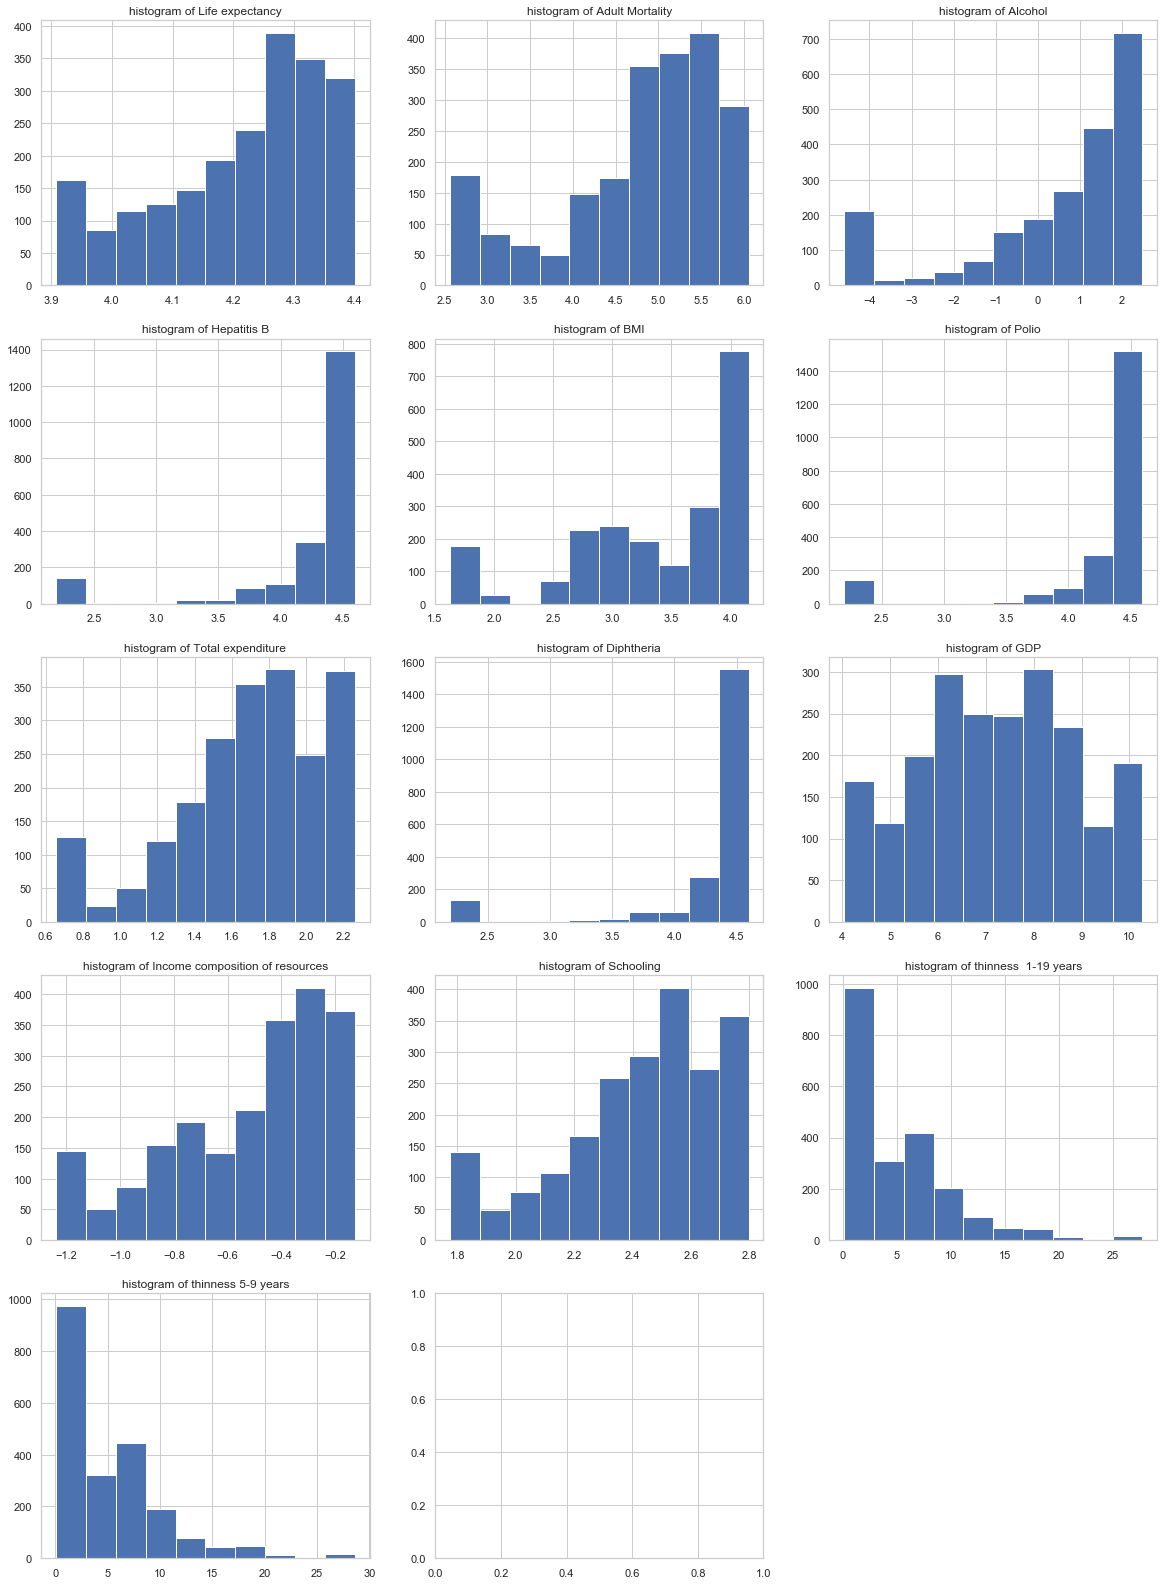

In [27]:
#Visually look at the distribution of the numercal variables (19)

plt.figure(figsize=(20,40))

# histograms of the data
plt.subplot(7, 3, 1)
plt.hist(expectancy_df['Life expectancy'])
plt.title("histogram of Life expectancy")

plt.subplot(7, 3, 2)
plt.hist(expectancy_df['Adult Mortality'])
plt.title("histogram of Adult Mortality")

plt.subplot(7, 3, 3)
plt.hist(expectancy_df['Alcohol'])
plt.title("histogram of Alcohol")

plt.subplot(7, 3, 4)
plt.hist(expectancy_df['Hepatitis B'])
plt.title("histogram of Hepatitis B")

plt.subplot(7, 3, 5)
plt.hist(expectancy_df['BMI'])
plt.title("histogram of BMI")

plt.subplot(7, 3, 6)
plt.hist(expectancy_df['Polio'])
plt.title("histogram of Polio")

plt.subplot(7, 3, 7)
plt.hist(expectancy_df['Total expenditure'])
plt.title("histogram of Total expenditure")

plt.subplot(7, 3, 8)
plt.hist(expectancy_df['Diphtheria'])
plt.title("histogram of Diphtheria")

plt.subplot(7, 3, 9)
plt.hist(expectancy_df['GDP'])
plt.title("histogram of GDP")

plt.subplot(7, 3, 10)
plt.hist(expectancy_df['Income composition of resources'])
plt.title("histogram of Income composition of resources")

plt.subplot(7, 3, 11)
plt.hist(expectancy_df['Schooling'])
plt.title("histogram of Schooling")

plt.subplot(7, 3, 12)
plt.hist(expectancy_df['thinness  1-19 years'])
plt.title("histogram of thinness  1-19 years")

plt.subplot(7, 3, 13)
plt.hist(expectancy_df['thinness 5-9 years'])
plt.title("histogram of thinness 5-9 years")

plt.subplot(7, 3, 14)
plt.hist(expectancy_df['Measles'])
plt.title("histogram of Measles")

plt.subplot(7, 3, 15)
plt.hist(expectancy_df['GDP'])
plt.title("histogram of GDP")

plt.subplot(7, 3, 16)
plt.hist(expectancy_df['Income composition of resources'])
plt.title("histogram of Income composition of resources")

plt.subplot(7, 3, 17)
plt.hist(expectancy_df['Schooling'])
plt.title("histogram of Schooling")

plt.subplot(7, 3, 18)
plt.hist(expectancy_df['thinness  1-19 years'])
plt.title("histogram of thinness  1-19 years")

plt.subplot(7, 3, 19)
plt.hist(np.log(expectancy_df['thinness 5-9 years']))
plt.title("histogram of thinness 5-9 years")

In [30]:
numeric_cols=expectancy_df.select_dtypes(include=[np.number]).columns
expectancy_df[numeric_cols].corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.171142,-0.014900,-0.022860,-0.194181,0.187645,0.079089,-0.141693,0.070968,-0.045756,0.055895,0.040924,0.113933,-0.097786,0.201839,0.016866,-0.052630,-0.057304,0.236243,0.233428
Life expectancy,0.171142,1.000000,-0.425060,-0.503694,0.249009,0.543953,0.166072,-0.287387,0.463348,-0.558282,0.290715,0.182583,0.323887,-0.832213,0.558901,-0.009106,-0.454107,-0.444052,0.797766,0.752390
Adult Mortality,-0.014900,-0.425060,1.000000,0.212575,-0.132607,-0.241146,-0.013475,0.104747,-0.209737,0.232401,-0.106672,-0.108418,-0.098212,0.369307,-0.246514,-0.016275,0.206861,0.218865,-0.314837,-0.297484
infant deaths,-0.022860,-0.503694,0.212575,1.000000,-0.306076,-0.408646,-0.096737,0.471921,-0.378686,0.994755,-0.199310,-0.219639,-0.192205,0.324079,-0.398682,0.214775,0.413701,0.421189,-0.486417,-0.527062
Alcohol,-0.194181,0.249009,-0.132607,-0.306076,1.000000,0.336376,0.031633,-0.174365,0.225175,-0.324512,0.131779,0.202167,0.107372,-0.049812,0.332103,-0.017797,-0.344563,-0.338537,0.363570,0.404291
percentage expenditure,0.187645,0.543953,-0.241146,-0.408646,0.336376,1.000000,0.053406,-0.253164,0.352965,-0.438995,0.158436,0.240601,0.191845,-0.362254,0.933761,-0.039666,-0.374012,-0.386191,0.588992,0.591275
Hepatitis B,0.079089,0.166072,-0.013475,-0.096737,0.031633,0.053406,1.000000,-0.133824,0.106459,-0.116135,0.316359,0.134230,0.480161,-0.165993,0.051725,-0.117977,-0.090975,-0.094563,0.132026,0.164875
Measles,-0.141693,-0.287387,0.104747,0.471921,-0.174365,-0.253164,-0.133824,1.000000,-0.265499,0.481895,-0.178986,-0.191006,-0.165507,0.183167,-0.229799,0.187553,0.306335,0.310304,-0.268574,-0.353226
BMI,0.070968,0.463348,-0.209737,-0.378686,0.225175,0.352965,0.106459,-0.265499,1.000000,-0.397445,0.145670,0.169945,0.136494,-0.373600,0.352775,-0.056930,-0.435101,-0.446654,0.464756,0.459478
under-five deaths,-0.045756,-0.558282,0.232401,0.994755,-0.324512,-0.438995,-0.116135,0.481895,-0.397445,1.000000,-0.221008,-0.214731,-0.218519,0.381372,-0.432151,0.204989,0.423783,0.428527,-0.538565,-0.573827


The features with the greatest positive correlations (>.25) are: Alcohol, % expenditure, Polio, Diptheria, Income Composition and Schooling.  The features with the greatest negative correlations (>-.25) are: thiness (2), HIV/AIDS, under-five deaths, Measles and Infant deaths.   

### 4) In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase.

- More concretely, you may discard some variables that are very correlated with the other ones or the variables 
  that you think irrelevant with the life expectancy.